In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, minimize
import time
from keras.applications import vgg16
from keras import backend as K
from keras import Model

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

In [4]:
base_image_path = './images/style_transfer/content.jpg'
style_reference_image_path = './images/style_transfer/style.png'

In [5]:
def preprocess_image(image_path, img_nrows = 224, img_ncols = 224):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [6]:
def unpreprocessing(img):
    img[...,0] += 103.939
    img[...,1] += 116.779
    img[...,2] += 126.68
    return img[..., ::-1]

In [7]:
def scale_image(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [8]:
content_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_reference_image_path)

In [9]:
model = vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [10]:
content_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3']
content_model = Model(model.input, [layer.output for layer in model.layers if layer.name in content_layers])

In [11]:
content_target = [K.variable(target) for target in content_model.predict(content_image)]

In [133]:
style_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
style_model = Model(model.input, [layer.output for layer in model.layers if layer.name in style_layers])

In [134]:
def get_content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [135]:
content_weights = [1, 2, 3]
content_loss = K.sum([content_weights[i] * get_content_loss(content_target[i], content_model.output[i]) for i in range(len(content_target))])

In [136]:
def gram_matrix(img):
    # input (H, W, C)
    # first convert to (C, H*W)
    shape = img.shape[1:]
    img = K.reshape(img, shape)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    # gram = XX^T / N
    gram = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return gram

def get_style_loss(img, target_img):
    return K.sum(K.square(gram_matrix(img) - gram_matrix(target_img)))

In [137]:
style_target = [K.variable(target) for target in style_model.predict(style_image)]

In [138]:
style_weights = [1, 1, 1, 10, 20]
style_loss = K.sum([style_weights[i] * get_style_loss(style_target[i], style_model.output[i]) for i in range(len(style_target))])

In [139]:
def get_total_loss(style_loss, content_loss, style_weight=1.0, content_weight=50.0):
    return style_weight * style_loss + content_weight * content_loss

In [140]:
loss = get_total_loss(style_loss, content_loss)

In [141]:
grads = K.gradients(loss, model.input)

In [142]:
get_loss_and_grads = K.function(inputs=[model.input], outputs=[loss] + grads)

In [143]:
batch_shape = content_image.shape
def get_loss_and_grads_wrapper(x):
    loss, grads = get_loss_and_grads([x.reshape(*batch_shape)])
    return loss.astype(np.float64), grads.flatten().astype(np.float64)

In [144]:
random_image = np.random.random(np.prod(batch_shape))
losses = []
for i in range(20):
    random_image, l, _ = fmin_l_bfgs_b(func=get_loss_and_grads_wrapper, x0=random_image, maxfun=20)
    random_image = np.clip(random_image, -127, 127)
    losses.append(l)

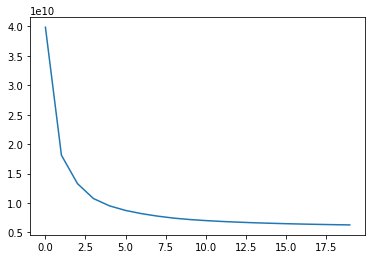

In [145]:
plt.plot(losses)

In [146]:
final_image = unpreprocessing(random_image.reshape(224, 224, 3))

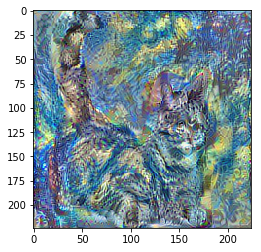

In [147]:
plt.imshow(scale_image(final_image))